In [552]:
# Nome do Candidato: Igor Alan Albuquerque de Sousa
# Desafio Técnico: Cientista de Dados - Murabei
# Objetivo: Previsão do resultado normalizado (normexam) e análise da eficiência dos tipos de escola

In [553]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

In [554]:
#após a primeira leitura dos dados vi o separador era ; e não o , padrão
cat_school = pd.read_csv('cat_school_data.csv', sep=';')

In [555]:
#percebi que o valor type é redudante com o valor schgend pois ele vai ser mxd se for escola mista ou sngl se não for
cat_school = cat_school[cat_school['variable'] != 'type']
# Renomear a coluna 'value' para 'schgend'
cat_school = cat_school.rename(columns={'value': 'schgend'})

# Remover a coluna 'variable'
cat_school = cat_school.drop(columns=['variable'])
cat_school.head()

,school,schgend
0,1,mixed
1,2,girls
2,3,mixed
3,4,mixed
4,5,mixed


In [556]:
cat_student = pd.read_csv('cat_student_data.csv', sep=';')

In [557]:
# Percebi que o mesmo aluno tem multiplas linhas no dataset, sendo uma para cada uma de suas variaveis
#agregei as variaveis de cada estudante em uma unica linha
cat_student_pivot = cat_student.pivot_table(
    index=['school', 'student'],
    columns='variable',
    values='value',
    aggfunc='first'
).reset_index()

cat_student_pivot.columns.name = None
cat_student = cat_student_pivot
cat_student.head()

,school,student,intake,sex,vr
0,1,1,bottom 25%,F,mid 50%
1,1,4,mid 50%,F,mid 50%
2,1,6,mid 50%,M,mid 50%
3,1,7,top 25%,M,mid 50%
4,1,13,mid 50%,M,mid 50%


In [558]:
num_school = pd.read_csv('num_school_data.csv', sep=';')

In [559]:
#vi que nesse dataset variable tem apenas uma variavel então posso usar a logica de renomear e deletar do primeiro nesse
num_school = num_school.rename(columns={'value': 'schavg'})

num_school = num_school.drop(columns=['variable'])
num_school.head()

,school,schavg
0,1,"0,1661752"
1,2,"0,3951492"
2,3,"0,5141552"
3,4,"0,0917642"
4,5,"0,2105252"


In [560]:
num_student = pd.read_csv('num_student_data.csv', sep=';')
print(num_student['variable'].unique())

['normexam' 'standLRT']


In [561]:
# Reorganizar o DataFrame para que cada estudante tenha uma única linha usando a mesma logica que apliquei a num_school
student_data_pivot = num_student.pivot_table(
    index=['school', 'student'],
    columns='variable',
    values='value',
    aggfunc='first'
).reset_index()

student_data_pivot.columns.name = None
student_data_pivot['student'] = student_data_pivot['student'].astype(int)
num_student = student_data_pivot
num_student.head()

,school,student,normexam,standLRT
0,1,1,"1,5061852","0,7843622"
1,1,4,"-0,555112","-1,03397"
2,1,6,"-1,335315","-0,951318"
3,1,7,"-0,555112","-2,356393"
4,1,13,"-0,197611","-0,290107"


In [562]:
# Realizar o merge dos dois DataFrames de escola
school_complete = pd.merge(cat_school, num_school, on='school', how='inner')
school_complete

,school,schgend,schavg
0,1,mixed,"0,1661752"
1,2,girls,"0,3951492"
2,3,mixed,"0,5141552"
3,4,mixed,"0,0917642"
4,5,mixed,"0,2105252"
...,...,...,...
60,61,mixed,"-0,020198"
61,62,mixed,"0,1673862"
62,63,mixed,"0,1562112"
63,64,boys,"0,4341442"


In [563]:
# Fazer o merge entre num_student e cat_student
students_complete = pd.merge(num_student, cat_student, on=['school', 'student'], how='inner')
students_complete

,school,student,normexam,standLRT,intake,sex,vr
0,1,1,"1,5061852","0,7843622",bottom 25%,F,mid 50%
1,1,4,"-0,555112","-1,03397",mid 50%,F,mid 50%
2,1,6,"-1,335315","-0,951318",mid 50%,M,mid 50%
3,1,7,"-0,555112","-2,356393",top 25%,M,mid 50%
4,1,13,"-0,197611","-0,290107",mid 50%,M,mid 50%
...,...,...,...,...,...,...,...
4005,65,148,"-0,623051","0,2884532",mid 50%,F,mid 50%
4006,65,152,"0,1340672","-0,207455",bottom 25%,F,mid 50%
4007,65,153,NaN,"-1,61253",top 25%,F,mid 50%
4008,65,154,"0,4781942","-0,124804",mid 50%,F,mid 50%


In [564]:
#juntar o dataframe de escola e estudante em um dataframe final que vai ser usado para o treino
final_df = pd.merge(school_complete, students_complete, on='school', how='inner')
#as variaveis numericas estavam como strings e não numeros
final_df['schavg'] = final_df['schavg'].str.replace(',', '.').astype(float)
final_df['standLRT'] = final_df['standLRT'].str.replace(',', '.').astype(float)
final_df['normexam'] = final_df['normexam'].str.replace(',', '.').astype(float)
final_df

,school,schgend,schavg,student,normexam,standLRT,intake,sex,vr
0,1,mixed,0.166175,1,1.506185,0.784362,bottom 25%,F,mid 50%
1,1,mixed,0.166175,4,-0.555112,-1.033970,mid 50%,F,mid 50%
2,1,mixed,0.166175,6,-1.335315,-0.951318,mid 50%,M,mid 50%
3,1,mixed,0.166175,7,-0.555112,-2.356393,top 25%,M,mid 50%
4,1,mixed,0.166175,13,-0.197611,-0.290107,mid 50%,M,mid 50%
...,...,...,...,...,...,...,...,...,...
4005,65,girls,-0.235350,148,-0.623051,0.288453,mid 50%,F,mid 50%
4006,65,girls,-0.235350,152,0.134067,-0.207455,bottom 25%,F,mid 50%
4007,65,girls,-0.235350,153,NaN,-1.612530,top 25%,F,mid 50%
4008,65,girls,-0.235350,154,0.478194,-0.124804,mid 50%,F,mid 50%


In [565]:
#tava dando erro no treinamento por NaN. Vi que o NaN esta em diversas colunas e que perderia daria muito trabalho analisar os padrões
#de cada escola e tipo de aluno para preencher com valores provaveis então decidi aplicar um dropna
final_df = final_df.dropna().reset_index(drop=True)
final_df

,school,schgend,schavg,student,normexam,standLRT,intake,sex,vr
0,1,mixed,0.166175,1,1.506185,0.784362,bottom 25%,F,mid 50%
1,1,mixed,0.166175,4,-0.555112,-1.033970,mid 50%,F,mid 50%
2,1,mixed,0.166175,6,-1.335315,-0.951318,mid 50%,M,mid 50%
3,1,mixed,0.166175,7,-0.555112,-2.356393,top 25%,M,mid 50%
4,1,mixed,0.166175,13,-0.197611,-0.290107,mid 50%,M,mid 50%
...,...,...,...,...,...,...,...,...,...
3702,65,girls,-0.235350,147,1.109438,1.032317,bottom 25%,F,mid 50%
3703,65,girls,-0.235350,148,-0.623051,0.288453,mid 50%,F,mid 50%
3704,65,girls,-0.235350,152,0.134067,-0.207455,bottom 25%,F,mid 50%
3705,65,girls,-0.235350,154,0.478194,-0.124804,mid 50%,F,mid 50%


In [566]:
# Separar features e target
X = final_df[['schgend', 'schavg', 'standLRT', 'intake', 'sex', 'vr']]  # Features
y = final_df['normexam']  # Target

# Verificar as features selecionadas
print(X.head())
print(y.head())

  schgend    schavg  standLRT      intake sex       vr
0   mixed  0.166175  0.784362  bottom 25%   F  mid 50%
1   mixed  0.166175 -1.033970     mid 50%   F  mid 50%
2   mixed  0.166175 -0.951318     mid 50%   M  mid 50%
3   mixed  0.166175 -2.356393     top 25%   M  mid 50%
4   mixed  0.166175 -0.290107     mid 50%   M  mid 50%
0    1.506185
1   -0.555112
2   -1.335315
3   -0.555112
4   -0.197611
Name: normexam, dtype: float64


In [567]:
#vou usar um metodo de arvore gradiente que xgb que não lida bem com variaveis categoricas então vou usar one hot encoding já que cada
#coluna categorica tem poucos valores possiveis
X = pd.get_dummies(X, columns=['schgend', 'intake', 'sex', 'vr'])
X.head()

,schavg,standLRT,schgend_boys,schgend_girls,schgend_mixed,intake_bottom 25%,intake_mid 50%,intake_top 25%,sex_F,sex_M,vr_bottom 25%,vr_mid 50%,vr_top 25%
0,0.166175,0.784362,False,False,True,True,False,False,True,False,False,True,False
1,0.166175,-1.033970,False,False,True,False,True,False,True,False,False,True,False
2,0.166175,-0.951318,False,False,True,False,True,False,False,True,False,True,False
3,0.166175,-2.356393,False,False,True,False,False,True,False,True,False,True,False
4,0.166175,-0.290107,False,False,True,False,True,False,False,True,False,True,False


In [568]:
# Dividir os dados em treino e teste
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)
# Dividir os dados restantes em validação e teste
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# Verificar tamanhos dos conjuntos
print(f'Treino: {X_train.shape}, Validação: {X_val.shape}, Teste: {X_test.shape}')

Treino: (2780, 13), Validação: (463, 13), Teste: (464, 13)


In [569]:
# Instanciar o modelo XGB
model = xgb.XGBRegressor(
    tree_method="hist",
    device="cuda",
    early_stopping_rounds=10,
    n_estimators=50,
    learning_rate=0.1,
    max_depth=6,
    eval_metric="rmse",
    random_state=42
)

# Treinar o modelo com os dados de treino
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:31:49] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:31:49] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [570]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(y.min(), y.max(), y.mean())

Mean Absolute Error (MAE): 0.6039918836377985
Root Mean Squared Error (RMSE): 0.7634743810394993
-3.666072 3.6660912 0.0015736972754248567


In [571]:
final_df['normexam_pred'] = model.predict(X)
avg_by_school = final_df.groupby('schgend')['normexam_pred'].mean()
print(avg_by_school)

schgend
boys     0.037883
girls    0.140826
mixed   -0.097617
Name: normexam_pred, dtype: float32


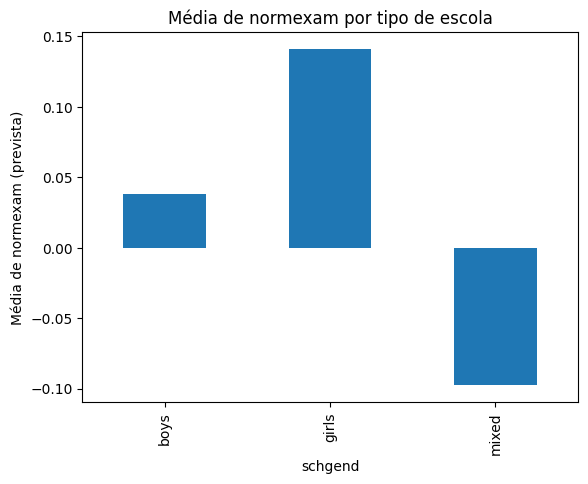

In [572]:
avg_by_school.plot(kind='bar', title='Média de normexam por tipo de escola')
plt.ylabel('Média de normexam (prevista)')
plt.show()

In [573]:
boys_scores = final_df[final_df['schgend'] == 'boys']['normexam_pred']
girls_scores = final_df[final_df['schgend'] == 'girls']['normexam_pred']
mixed_scores = final_df[final_df['schgend'] == 'mixed']['normexam_pred']

f_stat, p_value = f_oneway(boys_scores, girls_scores, mixed_scores)
print(f"F-statistic: {f_stat}, p-value: {p_value}")

F-statistic: 51.513763128539786, p-value: 8.577246698516732e-23


O intervalo de valores de normexam é de aproximadamente -3.66 a 3.66, o que significa que os valores previstos para as médias de cada tipo de escola estão próximos ao centro da escala (0). Isso sugere que a maioria dos estudantes apresenta um desempenho próximo à média.

Mesmo assim, escolas exclusivas para um único gênero mostraram um desempenho ligeiramente superior às escolas mistas. Escolas exclusivamente para meninas registraram a maior média prevista (0.14), indicando um desempenho levemente acima da média geral. Escolas exclusivamente para meninos também apresentaram um desempenho positivo (0.03), embora mais próximo do valor médio.

Por outro lado, escolas mistas registraram a menor média prevista (-0.09), ficando abaixo da média das escolas exclusivas para um único gênero. Isso pode sugerir que escolas mistas são menos eficazes para o aprendizado em comparação com escolas exclusivas para meninos ou meninas.

Apliquei o teste ANOVA, que retorna dois parâmetros principais: F-statistic e p-value.

Quanto maior o valor da F-statistic, maior a evidência de que há diferenças entre os indivíduos dos grupos. Neste caso, o valor 51.51 é relativamente alto, indicando diferenças substanciais entre as médias dos grupos.

O p-value representa a probabilidade de as diferenças observadas entre os grupos serem devidas ao acaso. Quanto menor o p-value, menor a chance de que as diferenças sejam aleatórias. O p-value obtido é extremamente pequeno (8.58 × 10⁻²³), indicando que é altamente improvável que as diferenças sejam explicadas apenas pelo acaso.

Embora as diferenças sejam pequenas, essa análise indica uma tendência que escolas de gênero único sejam melhores para aprendizado.